**Préparation du dataset et prétraitement des données**

Ce livrable concerne la phase finale du traitement nécessaire, qui vise à créer un réseau de neurones capable de générer des légendes pour des images à partir du jeu de données MS COCO. Le réseau se compose de deux composants : une partie CNN qui encode les images en une représentation interne, et une partie RNN qui utilise cette représentation pour prédire les légendes séquentiellement. Avant d'entraîner le modèle, les images subissent un prétraitement par un CNN préalablement entraîné pour la classification.

Description du livrable : Le livrable est un notebook Jupyter comprenant les éléments suivants :

1. Une représentation schématique complète de l'architecture du réseau utilisé pour la génération de légendes, avec une explication du type de CNN utilisé pour les prétraitements.

2. Une brève explication des prétraitements appliqués aux images et au texte.

3. Le code qui détaille l'architecture du CNN et du RNN utilisés dans le processus de génération de légendes.

4. Des graphiques illustrant l'évolution des performances du réseau au cours de l'entraînement, ainsi que des exemples de légendes générées pour des tests.

Pour accomplir cela, nous utilisons un modèle basé sur l'attention, ce qui nous permet de comprendre quelles parties de l'image le modèle privilégie lors de la génération de légendes.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

En exécutant ce notebook, le jeu de données MS-COCO (https://www.kaggle.com/mnassrib/ms-coco) sera téléchargé. Ensuite, un sous-ensemble d'images sera soumis à un processus de prétraitement et mis en mémoire cache en utilisant le modèle Inception V3. Après cela, un modèle de type encodeur-décodeur sera formé. Enfin, ce modèle précédemment entraîné sera utilisé pour générer des légendes pour de nouvelles images.

Notre processus de formation se limitera à un ensemble de données relativement restreint, comprenant environ 30 000 légendes pour 6 000 images (environ 5 légendes par image dans le jeu de données).

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import glob
import cv2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], False)

## Téléchargement et préparation du jeu de données MS-COCO

Nous optons pour l'utilisation du jeu de données MS-COCO (https://www.kaggle.com/mnassrib/ms-coco) pour l'entraînement du modèle. Ce jeu de données compte plus de 82 000 images, et chacune de ces images est associée à au moins 5 légendes différentes. Le code ci-dessous permet de télécharger automatiquement ce jeu de données.

In [ ]:
# Téléchargement des fichiers de sous-titres
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252872794/252872794 [==============================] - 23s 0us/step


In [ ]:
    annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"
    X_data = []
    img_height, img_width = 300, 300
    batch_size = 128
    files = glob.glob("/train2014")

    for myFile in files:
        image = cv2.imread(myFile)
        image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_RGB, (img_width, img_height))
        X_data.append(image_resized)

    print('X_data shape:', np.array(X_data).shape)

X_data shape: (0,)


## Explication : Limite de la taille de notre jeu d'entraînement

Pour réduire la puissance de calcul nécessaire à l'entraînement de notre modèle, nous faisons le choix de travailler avec un sous-ensemble de 30 000 légendes. Bien que l'ajout de davantage de données puisse améliorer la qualité des légendes générées, nos ressources matérielles actuelles ne sont pas suffisamment performantes pour nous permettre d'augmenter la taille de notre ensemble d'entraînement.

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
PATH = os.path.abspath('../input/ms-coco/train2014/train2014/COCO_train2014_')

Regroupe tous les sous-titres appartenant à la même image

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Sélection des 6000 premières images du jeu de données aléatoire
# Chaque image à environ 5 sous-titres qui lui sont associés, cela équivaut
# donc à 30,000 sous-titres différents.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))


6000


 Ce code combine les légendes associées aux images avec les chemins des images dans deux listes distinctes, train_captions et img_name_vector.

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> Men standing around a motorcycle in a garage. <end>


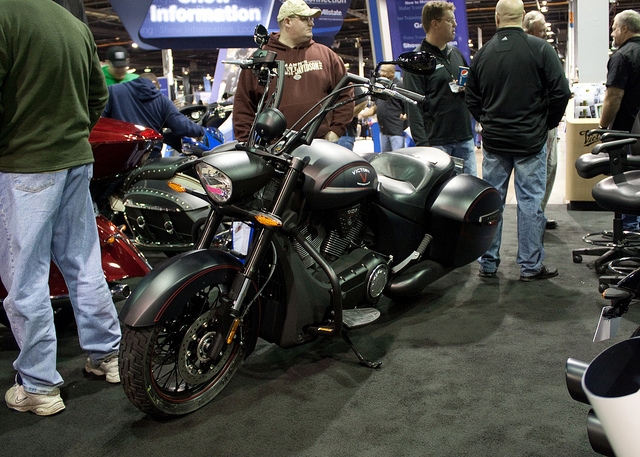

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Prétraitement des images avec InceptionV3

Nous procédons ici à l'acquisition du modèle InceptionV3, qui a été préalablement entraîné sur le jeu de données **Imagenet**, dans le but de classer chaque image. Les caractéristiques essentielles seront extraites de la dernière couche convolutive du modèle.

En premier lieu, nous ajusterons le format des images pour les adapter aux exigences d'InceptionV3 en effectuant les étapes suivantes :
* Redimensionnement de l'image à 299x299 pixels.
* Utilisation de la fonction **preprocess_input** pour normaliser les valeurs des pixels de manière à ce qu'elles se situent dans la plage de -1 à 1 plutôt que de 0 à 255. Cette normalisation est nécessaire pour permettre l'entraînement du modèle, une opération que nous avons déjà réalisée dans les livrables précédents.

**Chargement des images dans le modèle InceptionV3**

In [ ]:
def load_image(image_path):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialisation d'InceptionV3 et chargement des poids pré-entraînés Imagenet

À ce stade, nous créons un modèle tf.keras, dont la couche de sortie est la dernière couche convolutive de l'architecture InceptionV3. La forme de la sortie de cette couche est de ```8x8x2048```. Nous choisissons la dernière couche convolutive en raison de l'utilisation du captioning basé sur l'attention.

Voici comment le processus se déroule :
* Chaque image est acheminée à travers le réseau, et le vecteur résultant est stocké dans un dictionnaire (image_name --> feature_vector).
* Une fois que toutes les images ont été traitées par le réseau, nous enregistrons ce dictionnaire sur le disque.

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer);

87910968/87910968 [==============================] - 4s 0us/step


## Extraction des caractéristiques avec InceptionV3

Nous effectuons le prétraitement de chaque image à l'aide d'InceptionV3 et mettons en cache la sortie. La mise en cache en mémoire RAM est rapide, mais elle a un coût élevé en termes de mémoire, car elle nécessite de stocker 8 * 8 * 2048 valeurs en virgule flottante par image. Cependant, nous n'avons pas d'autre option, car Kaggle ne permet pas de sauvegarder des fichiers.

Il est possible d'améliorer les performances en utilisant une stratégie de mise en cache plus sophistiquée, par exemple en fragmentant les images pour réduire les accès E/S aléatoires sur le disque. Cependant, cette approche nécessiterait un code plus complexe.

In [ ]:
# Récupération d'images uniques
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
np_images={}
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np_images[path_of_feature]=bf.numpy()

## Prétraitement et tokenisation des légendes

Le processus de prétraitement et de tokenisation des légendes se déroule comme suit :

1. Tout d'abord, nous effectuons la tokenisation des légendes en séparant les mots par exemple en utilisant des espaces. Cela nous donne un vocabulaire comprenant chaque mot unique présent dans les données, tels que "surfing", "football", etc.

2. Ensuite, nous imposons une limitation sur la taille du vocabulaire en ne retenant que les 5 000 mots les plus fréquemment utilisés, ce qui permet d'économiser de la mémoire. Les autres mots sont remplacés par le token "UNK" (pour "unknown", c'est-à-dire inconnu en anglais).

3. Nous créons des correspondances bidirectionnelles entre les mots et leurs indices, sous forme de mappages mot vers index et index vers mot.

4. Enfin, nous complétons toutes les séquences de mots pour qu'elles aient la même longueur que la plus longue séquence, ce qui facilite le traitement par le modèle.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)


### Partitionnement des données en ensembles d'entraînement et de validation

Dans cette étape, nous divisons notre jeu de données en deux ensembles de manière aléatoire. Nous avons opté pour une répartition de **80% - 20%**, ce qui correspond à 24 000 images pour l'ensemble d'entraînement et 6 000 images pour l'ensemble de validation.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Création des jeux d'entraînement et de validation, en utilisant une séparation 80-20 aléatoirement.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24014, 24014, 6002, 6002)

### Création d'un jeu de données tf.data pour l'entraînement
Nos images et légendes sont prêtes, et nous sommes maintenant en mesure de créer un ensemble de données `tf.data` pour faciliter et optimiser le processus d'entraînement de notre modèle. Nous allons configurer les paramètres de notre ensemble de données.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 5000
num_steps = len(img_name_train) // BATCH_SIZE
# La forme du vecteur extrait d'InceptionV3 est (64, 2048)
# Ces deux variables représentent cette forme de vecteur.
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Chargement des fichiers numpy
def map_func(img_name, cap):
    img_tensor=np_images[img_name.decode('utf-8')].astype(np.float32)
    return img_tensor, cap

La fonction `map_func` renvoie le fichier numpy associé, qui contient les caractéristiques extraites par InceptionV3.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Utilisation de map pour charger les fichiers numpy en parallèles
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Mélange et batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Nous établissons un ensemble de données contenant les caractéristiques extraites par InceptionV3, puis nous le mettons en cache pour accélérer l'accès aux données.

# Définition et construction du modèle

Notre modèle de captioning suit une architecture basée sur Bahdanau, ce qui signifie qu'il se compose de trois grandes parties distinctes : l'encodeur, le décodeur, et l'algorithme d'attention. Voici les étapes que nous suivons :

1. Nous extrayons les caractéristiques de la couche convolutive basse d'InceptionV3, ce qui nous donne un vecteur de forme (8, 8, 2048).
2. Nous remodelons ce vecteur pour obtenir une forme de (64, 2048).
3. Ce vecteur est ensuite acheminé vers l'encodeur CNN, qui consiste en une seule couche complètement connectée.
4. Le RNN, dans ce cas un GRU, utilise cette représentation de l'image pour prédire le prochain mot dans la séquence.

Nous avons choisi d'implémenter cette architecture car elle correspond à nos besoins. Bien qu'il existe d'autres architectures possibles, nous avons préféré utiliser une que nous maîtrisons, compte tenu des contraintes de temps.

La classe CNN_Encoder est utilisée pour prendre des caractéristiques d'images prétraitées, les projeter dans un espace d'incorporation de dimension embedding_dim, et les passer à travers une fonction d'activation ReLU. Ces caractéristiques d'images projetées et transformées sont ensuite utilisées dans le reste du modèle pour générer des légendes pour les images.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Définition de l'algorithme d'attention


Nous définissons notre algorithme d'attention qui sera implémenté dans le RNN. L'attention examine chaque état caché de chaque nœud de l'encodeur à chaque étape du temps et décide ensuite duquel est le plus informatif pour effectuer des prédictions.

Le processus de l'algorithme d'attention se déroule comme suit :

1. L'encodeur génère un ensemble d'annotations à partir de la phrase d'entrée.
2. Ces annotations sont introduites dans un modèle d'alignement en conjonction avec l'état caché précédent du décodeur. Le modèle d'alignement utilise ces informations pour générer les scores d'attention.
3. Une fonction softmax est appliquée aux scores d'attention, les normalisant en valeurs de poids dans une plage allant de 0 à 1.
4. Ces poids, ainsi que les annotations calculées précédemment, sont utilisés pour générer un vecteur de contexte, qui est obtenu par une somme pondérée des annotations.
5. Le vecteur de contexte est ensuite introduit dans le décodeur, en combinaison avec l'état caché précédent du décodeur et la sortie précédente, pour calculer la sortie finale.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### Définition du RNN

Nous définissons la classe de notre RNN qui utilise le mécanisme des unités récurrentes à portes (GRU) pour prédire les mots. Le rôle du décodeur est de générer les mots cibles en se concentrant sur les informations les plus pertinentes extraites de la phrase source. Pour cela, il fait appel au mécanisme d'attention que nous avons précédemment défini.

Les étapes du décodeur sont les suivantes :

1. Nous récupérons les caractéristiques extraites des images.
2. Nous appliquons l'algorithme d'attention pour déterminer l'importance de chaque caractéristique.
3. Nous construisons une séquence de mots en utilisant le mécanisme GRU, suivi de couches denses pour la génération des mots.

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)


    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x],axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


### Définition des paramètres

Nous initialisons notre encodeur CNN et notre décodeur RNN, puis nous configurons l'optimiseur Adam, qui a donné les meilleurs résultats lors de nos tests. La perte (loss) "sparse categorical cross-entropy" est appropriée dans notre cas, car nous générons des phrases qui doivent correspondre aux labels.

In [ ]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam() #SOLUTION
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

### Définition des étapes d'entraînement

Nous précisons les étapes de notre processus d'entraînement. Les données sont acheminées à travers l'encodeur, puis le décodeur. Ensuite, nous comparons les prédictions aux labels et mettons à jour les poids du réseau de neurones à l'aide de l'optimiseur.

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(['<start>'])[0]] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

### Point de contrôle (Checkpoint)

Nous mettons en place un point de contrôle (checkpoint) pour pouvoir récupérer le modèle le plus performant pendant l'entraînement. Cela nous permet de sauvegarder les poids du modèle à un certain stade de l'entraînement pour les réutiliser ultérieurement.

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Execution du modèle

In [ ]:
EPOCHS = 30


for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9508
Epoch 1 Batch 100 Loss 1.1816
Epoch 1 Batch 200 Loss 0.9813
Epoch 1 Batch 300 Loss 0.8938
Epoch 1 Loss 1.019664
Time taken for 1 epoch 165.63 sec

Epoch 2 Batch 0 Loss 0.8683
Epoch 2 Batch 100 Loss 0.8101
Epoch 2 Batch 200 Loss 0.7580
Epoch 2 Batch 300 Loss 0.7174
Epoch 2 Loss 0.772202
Time taken for 1 epoch 55.17 sec

Epoch 3 Batch 0 Loss 0.7594
Epoch 3 Batch 100 Loss 0.7338
Epoch 3 Batch 200 Loss 0.6461
Epoch 3 Batch 300 Loss 0.6626
Epoch 3 Loss 0.696973
Time taken for 1 epoch 54.04 sec

Epoch 4 Batch 0 Loss 0.6890
Epoch 4 Batch 100 Loss 0.7140
Epoch 4 Batch 200 Loss 0.6490
Epoch 4 Batch 300 Loss 0.6024
Epoch 4 Loss 0.646661
Time taken for 1 epoch 54.49 sec

Epoch 5 Batch 0 Loss 0.6599
Epoch 5 Batch 100 Loss 0.6179
Epoch 5 Batch 200 Loss 0.6518
Epoch 5 Batch 300 Loss 0.6165
Epoch 5 Loss 0.607524
Time taken for 1 epoch 53.60 sec

Epoch 6 Batch 0 Loss 0.6176
Epoch 6 Batch 100 Loss 0.5512
Epoch 6 Batch 200 Loss 0.5718
Epoch 6 Batch 300 Loss 0.6082
Epoch 6 Los

**Analyse des performances**

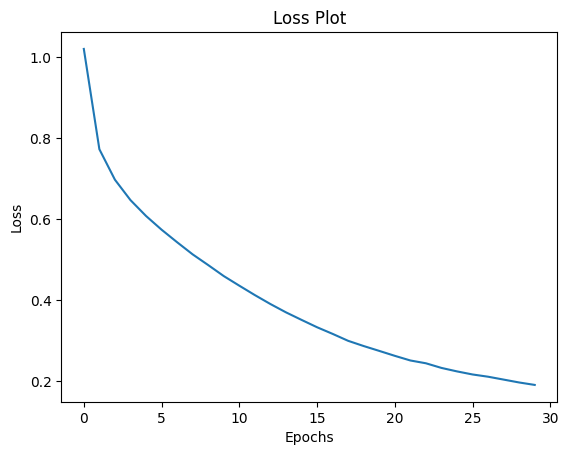

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Le tracé de la perte d'un modèle d'apprentissage automatique décrit son évolution au fil de l'entraînement. Dans ce cas, la perte commence à 1, indiquant une performance initialement médiocre, mais diminue progressivement pour atteindre 0.19 à la 30e époque. Cette réduction de la perte reflète l'amélioration du modèle, passant d'une faible adéquation aux données d'entraînement à des prédictions plus précises. Cependant, il est important de noter que l'évaluation sur des données de validation ou de test est essentielle pour confirmer la capacité du modèle à généraliser correctement aux données inconnues.

### Test du modèle

Nous créons des fonctions pour afficher les résultats. La fonction 'evaluate' permet d'afficher les mots générés et l'image correspondante, tandis que 'attention' permet de visualiser les points d'attention identifiés par le modèle.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(['<start>'])][0], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(int(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

#Affichage du résultat


Real Caption: <start> a baseball player pitching a ball on a field. <end>
Prediction Caption: a baseball player holding bat in a field during a game. <end>


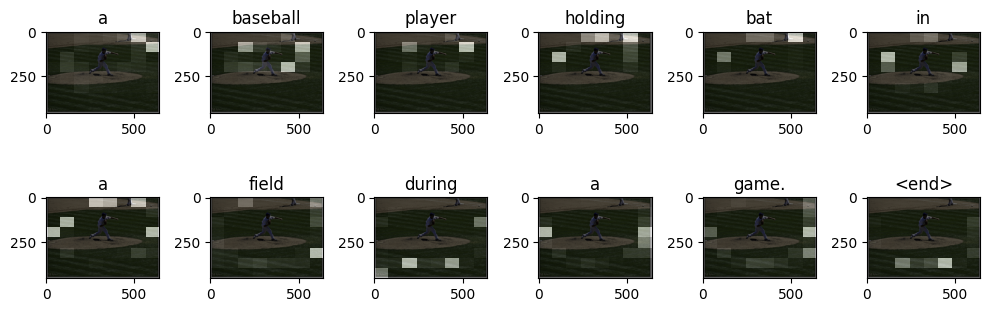

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)



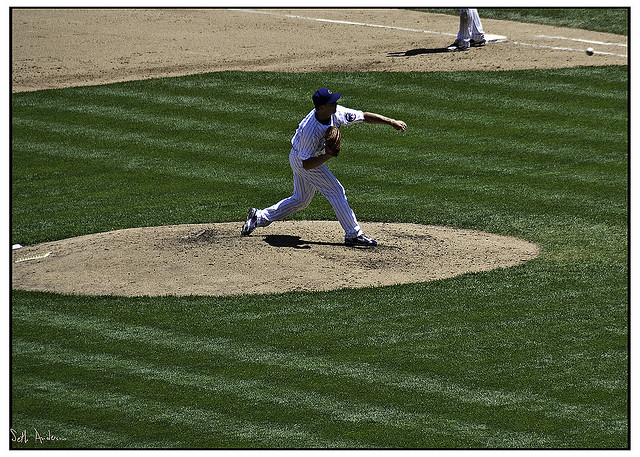

In [ ]:
Image.open(image)

Nous pouvons expérimenter sur une image du web.

Prediction Caption: a man on a surf board rides a wave <end>


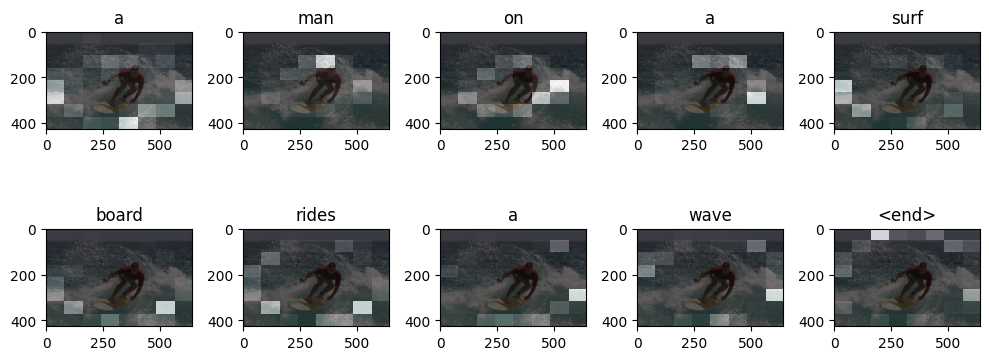

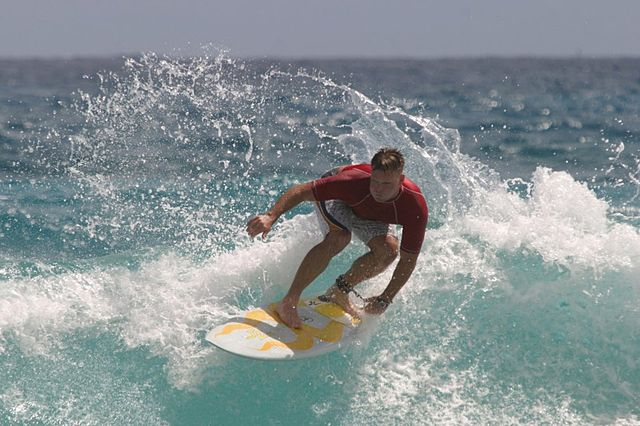

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Nous affichons une image sélectionnée au hasard ainsi que la prédiction générée par le modèle. Il est gratifiant de constater que les résultats sont satisfaisants.

# Pipeline

Nous utiliserons la même image pour cette expérience.

## Obtenir le modèle de classification et le modèle de débruitage

Nous récupérons les modèles provenant des livrables précédents.

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/input/model-binary/model_binary.h5')


In [ ]:
loaded_model.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Test sur le classificateur

Nous procédons à un test en utilisant le modèle de classification.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import cv2
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
def load_image1(infilename):
    import matplotlib.image as mpimg
    img = mpimg.imread(infilename)
    imgplot = plt.imshow(img)
    plt.show()

    img = cv2.imread(infilename)
    data = cv2.resize(img, dsize=(128,128))
    data = data[None,:,:,:]
    return data
def is_it_a_photo(img_path):
# Load and preprocess the single image
  img = image.load_img(img_path, target_size=IMAGE_SIZE)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img / 255.0  # Normalize the image

# Make predictions using the loaded model
  predictions = loaded_model.predict(img)
  load_image1(img_path)
  print(predictions)

# Define the threshold for classification
  threshold = 0.5
# Convert predicted probabilities to binary class labels
  if predictions[:, 1] > threshold:

    predicted_labels = "photo"
  else :
    predicted_labels = "NON_photo"


  print("Predicted labels:", predicted_labels)

# 'predictions' now contains the model's predictions for the single image






1/1 [==============================] - 0s 199ms/step


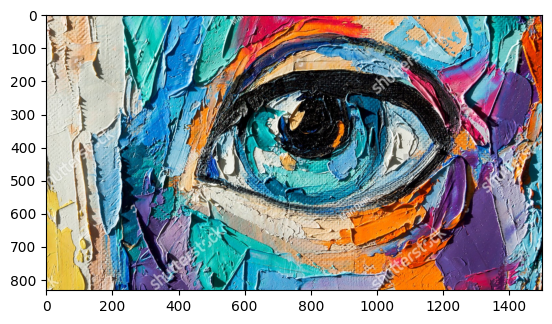

[[1. 0.]]
Predicted labels: NON_photo


In [ ]:
is_it_a_photo('/kaggle/input/test-image/painting_1.jpg')

1/1 [==============================] - 0s 20ms/step


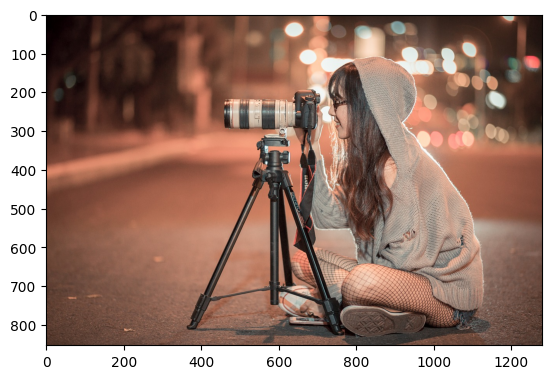

[[6.1711897e-10 1.0000000e+00]]
Predicted labels: photo


In [ ]:
is_it_a_photo('/kaggle/input/test-image/photo_3.jpg')

Notre classificateur a plus de difficulté à déterminer si une image est une photo que s'il s'agit d'autre chose, car lors de son entraînement, nous avions un plus grand nombre d'exemples d'autres types d'images que de photos.

## Test on denoiser

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model= load_model('/kaggle/input/model-denoising/model_denoising.h5')


In [ ]:
def add_noise(images, amount=0.1):
    '''
    Given an array of images [a shape of (None, Height, Width, Channels)],
    this function adds gaussian noise to every channel of the images
    '''
    '''
    Étant donné un tableau d'images [une forme de (Aucune, Hauteur, Largeur, Canaux)],
    cette fonction ajoute du bruit gaussien à chaque canal des images
    '''
    # Créer une matrice avec des valeurs avec une moyenne de 0 et un écart type de "montant"
    noise = np.random.normal(0, amount, images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]).reshape(images.shape)
    # Add noise to images
    noise_img = images+noise
    return noise_img



In [ ]:
TRAIN_SIZE = 384
INFERENCE_SIZE = 226
def open_images(paths, size=TRAIN_SIZE):
    '''
    Given an array of paths to images, this function opens those images,
    and returns them as an array of shape (None, Height, Width, Channels)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(size, size, 3))
        image = np.array(image)/255.0 # Normalize image pixel values to be between 0 and 1
        images.append(image)
    return np.array(images)

1/1 [==============================] - 1s 1s/step


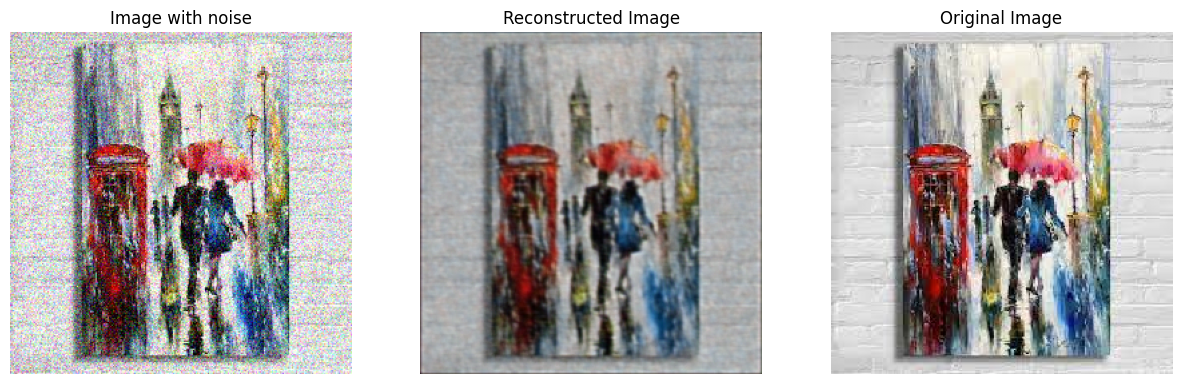

In [ ]:
def plot_results(noise_image, reconstructed_image, image):
    w = 15
    h = len(noise_image)*5
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = len(noise_image)
    for i in range(1, rows*columns, columns):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.title('Image with noise')
        plt.imshow(noise_images[int((i-1)/columns)])

        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title('Reconstructed Image')
        plt.imshow(reconstructed[int((i-1)/columns)])

        fig.add_subplot(rows, columns, i+2)
        plt.axis('off')
        plt.title('Original Image')
        plt.imshow(images[int((i-1)/columns)])

    plt.show()

batch_size = 1

paths = random.sample(["/content/painting_4.jpg"], batch_size)
images = open_images(paths, size=256)
# Amount of noise = random value between 0.1 and 0.15
amount = random.uniform(0.1,0.15)
noise_images = add_noise(images, amount=amount)
reconstructed = model.predict(noise_images)

plot_results(noise_images, reconstructed, images)

À gauche, nous avons l'image d'origine, tandis qu'à droite, nous avons l'image débruitée. Bien que nous perdions un peu en qualité d'image, le bruit a été considérablement réduit. Il est possible d'améliorer davantage notre auto-encodeur en augmentant la quantité de données d'entraînement ou en prolongeant le nombre d'epochs pour permettre au modèle de mieux apprendre la structure du bruit. Cependant, les résultats actuels restent satisfaisants dans la réduction du bruit de l'image.

/tmp/ipykernel_32/2447619950.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = loaded_model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


## Test on captioning

In [ ]:


def caption_my_image(image_url):
    image_extension = image_url[-4:]
    #image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

    result, attention_plot = evaluate(image_url)
    print('Prediction Caption:', ' '.join(result))

    plot_attention(image_url, result, attention_plot)

    # opening the image
    plt.imshow(Image.open(image_url))



Prediction Caption: a hot dog on a bun and fries <end>


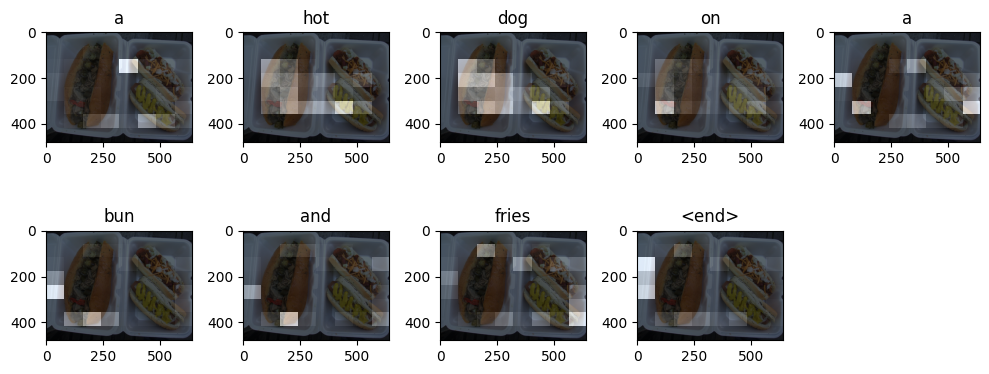

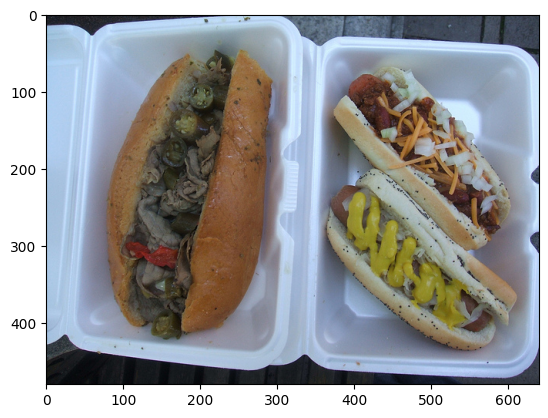

In [ ]:
caption_my_image('/kaggle/input/ms-coco/train2014/train2014/COCO_train2014_000000000321.jpg')

Il est encourageant de constater que notre modèle a réussi à identifier les éléments clés de l'image et à générer une description appropriée. Cela témoigne de l'efficacité de l'architecture que nous avons mise en place pour le captioning d'images.

## Conclusion
Au cours de ce projet, nous avons parcouru toutes les étapes d'un projet typique d'un Data Scientist. Nous avons soigneusement recueilli divers ensembles de données, les avons soumis à un processus de prétraitement et les avons adaptés pour les rendre compatibles avec chacun des modèles que nous avons examinés.

Dans notre premier livrable, nous avons effectué une classification des images fournies pour déterminer si elles est une photo ou non-photo. Pour notre deuxième livrable, nous avons entrepris la tâche de débruitage sur les images qui présentaient des éléments indésirables. Enfin, dans notre troisième livrable, nous avons mis au point un système automatisé de description du contenu des images, également connu sous le nom de "captioning".